99.9th percentile: 4.96


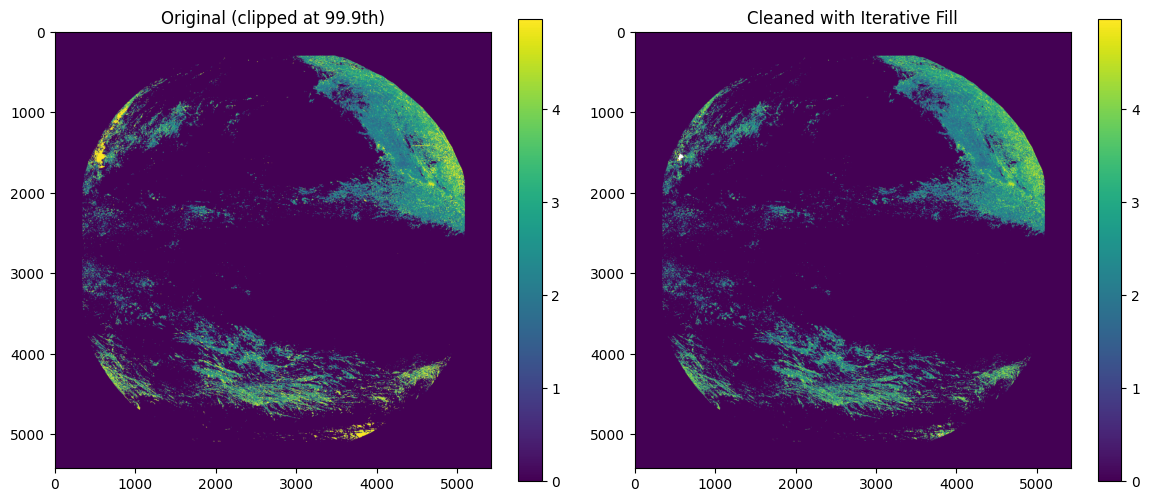

In [19]:
import rasterio
import numpy as np
from scipy.ndimage import generic_filter
import matplotlib.pyplot as plt

# Path to your GeoTIFF
geotiff_path = r"E:\GOES-R Lightning Data\WEST-RASTERS\west_mean_energy_2025.tif"
output_path = r"E:\GOES-R Lightning Data\WEST-RASTERS\west_mean_energy_2025_cleaned.tif"

# --- 1. Load raster ---
with rasterio.open(geotiff_path) as src:
    profile = src.profile
    data = src.read(1).astype(float)
    nodata = src.nodata

if nodata is not None:
    data = np.where(data == nodata, np.nan, data)

vals = data[~np.isnan(data)]

# --- 2. Determine thresholds ---
p999 = np.percentile(vals, 99)
print(f"99.9th percentile: {p999:.2f}")

# Mask values > 99.9th percentile
mask = data > p999
data_masked = np.where(mask, np.nan, data)

# --- 3. Neighborhood interpolation function ---
def interpolate_func(window):
    center = window[len(window)//2]
    if np.isnan(center):
        neighbors = window[~np.isnan(window)]
        if len(neighbors) == 0:
            return np.nan
        return np.median(neighbors)  # median is robust
    return center

# --- 4. Iterative fill until all NaNs are gone ---
def iterative_fill(arr, max_iter=10, window=3):
    filled = arr.copy()
    for i in range(max_iter):
        nan_mask = np.isnan(filled)
        if not nan_mask.any():
            print(f"All NaNs filled after {i} iterations")
            break
        filled = generic_filter(filled, interpolate_func, size=window, mode='nearest')
    return filled

interpolated = iterative_fill(data_masked, max_iter=10, window=3)

# --- 5. Save output ---
with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(interpolated.astype(profile["dtype"]), 1)

# --- 6. Plot before/after comparison ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(data, cmap="viridis", vmin=0, vmax=p999)
plt.title("Original (clipped at 99.9th)")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(interpolated, cmap="viridis", vmin=0, vmax=p999)
plt.title("Cleaned with Iterative Fill")
plt.colorbar()
plt.tight_layout()
plt.show()
